In [36]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism
import fsps
from spec_id import Scale_model

import dynesty

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [23]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1)
wave, flux = sp.get_spectrum(tage = 2.0, peraa = True)

Gs = Gen_spec('GND', 21156, 1.2529, '../beams/o151.0_21156.g102.A.fits', '../beams/o144.0_21156.g141.A.fits',
               g102_lims=[7000, 12000], g141_lims=[10000, 18000],
            phot_errterm = 0.03, decontam = False)  

Gs.Make_sim(0.019, 3.2, 0.2 , 1.2, 0)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/Github/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/vestrada/Github/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/vestrada/Github/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/vestrada/Gith

In [98]:
# prior transform
def prior_transform(u):
    # return m from 0.001 to 0.03
    # return a from 0.1 to 10
    m = 0.03 * u + 0.001
    a = 10. * u + 0.1
    return [m, a]

In [99]:
Bmwv,Bmflx = forward_model_grism(Gs.Bbeam, wave, flux)

def Resize(fit_wv, mwv, mfl):
    mfl = np.ma.masked_invalid(mfl)
    mfl.data[mfl.mask] = 0
    mfl = interp1d(mwv,mfl)(fit_wv)
    return mfl

# 3-D correlated multivariate normal log-likelihood

def loglikelihood(X):
    
    m,a = X
    """Multivariate normal log-likelihood."""
    sp.params['logzsol'] = np.log10( m[0] / 0.019)
    
    wave, flux = sp.get_spectrum(tage = a[0], peraa = True)
    
    mwv,mflx= forward_model_grism(Gs.Bbeam, wave * (1 + 1.2), flux)
    
    mfl = Resize(Gs.Bwv,mwv,mflx)
    
    C = Scale_model(Gs.SBflx, Gs.SBerr, mfl)
    
    return -0.5 * np.sum(((Gs.SBflx - mfl*C) / Gs.SBerr)**2)

In [100]:
# initialize our nested sampler
ndim = 2
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, nlive=100)

In [101]:
sampler.run_nested()


iter: 518+100 | bound: 58 | nc: 1 | ncall: 8997 | eff(%):  6.869 | loglstar:   -inf < -0.359 <    inf | logz: -3.235 +/-  0.149 | dlogz:  0.001 >  0.109            

In [102]:
res = sampler.results  # grab our results
print('Keys:', res.keys(),'\n')  # print accessible keys
res.summary()  # print a summary

Keys: dict_keys(['logwt', 'logz', 'logvol', 'bound', 'logzerr', 'niter', 'nlive', 'ncall', 'samples_bound', 'eff', 'bound_iter', 'samples_u', 'scale', 'information', 'samples_id', 'logl', 'samples', 'samples_it']) 

Summary
nlive: 100
niter: 518
ncall: 8997
eff(%):  6.869
logz: -3.235 +/-  0.149


In [103]:
sampler.run_nested(dlogz=0.1)

iter: 526+100 | bound: 61 | nc: 1 | ncall: 9348 | eff(%):  6.697 | loglstar:   -inf < -0.359 <    inf | logz: -3.235 +/-  0.150 | dlogz:  0.001 >  0.100            

In [104]:
dlogz_final = 0.01

from dynesty.results import print_fn

# continue sampling from where we left off
ncall = sampler.ncall  # internal calls
nit = sampler.it  # internal iteration
for it, results in enumerate(sampler.sample(dlogz=dlogz_final)):
    # split up our results
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzvar,
     h, nc, worst_it, boundidx, bounditer, eff, delta_logz) = results
    # add number of function calls
    ncall += nc
    nit += 1
    # print results
    print_fn(results, nit, ncall, dlogz=dlogz_final)

# add the remaining live points back into our final results 
# (they are removed from our set of dead points each time we start sampling)
for it2, results in enumerate(sampler.add_live_points()):
    # split up results
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzvar,
     h, nc, worst_it, boundidx, bounditer, eff, delta_logz) = results
    # print results
    print_fn(results, nit, ncall, add_live_it=it2+1, dlogz=dlogz_final)

res2 = sampler.results

iter: 754+100 | bound: 622 | nc: 1 | ncall: 59304 | eff(%):  1.438 | loglstar:   -inf < -0.359 <    inf | logz: -3.234 +/-  0.155 | dlogz:  0.000 >  0.010            

In [114]:
res.samples[:, 0]

array([[0.00138505, 0.0293084 ],
       [0.00192799, 0.00185455],
       [0.00322974, 0.02044281],
       ...,
       [0.0126034 , 0.02358788],
       [0.01260642, 0.00340408],
       [0.01260532, 0.02180357]])

<Figure size 720x720 with 0 Axes>

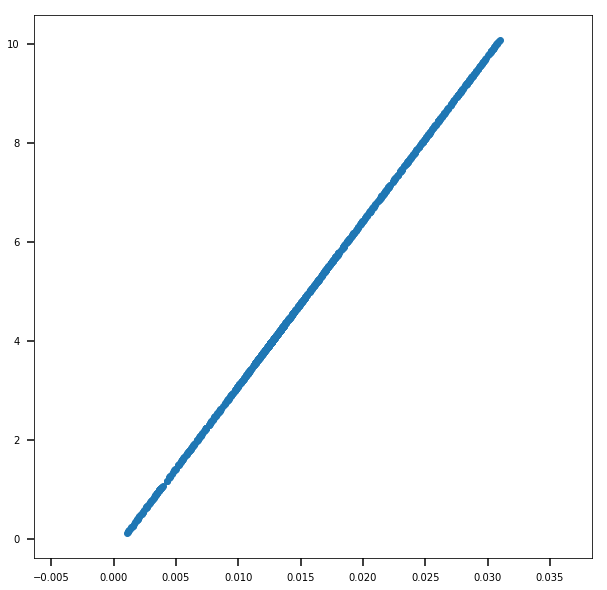

<Figure size 720x720 with 0 Axes>

In [115]:
plt.figure(figsize=(10, 10))

# plotting the initial run
plt.scatter(res.samples[:, 0], res.samples[:, 1],marker='o')#, c=np.exp(res.logwt) * 1e7, linewidths=(0.,),
#                cmap='coolwarm')

plt.figure(figsize=(10, 10))

# plt.scatter(res2.samples[:, 0], res2.samples[:, 0],marker='o', c=np.exp(res2.logwt) * 1e7, linewidths=(0.,),
#                cmap='coolwarm')
# plotting the extended run



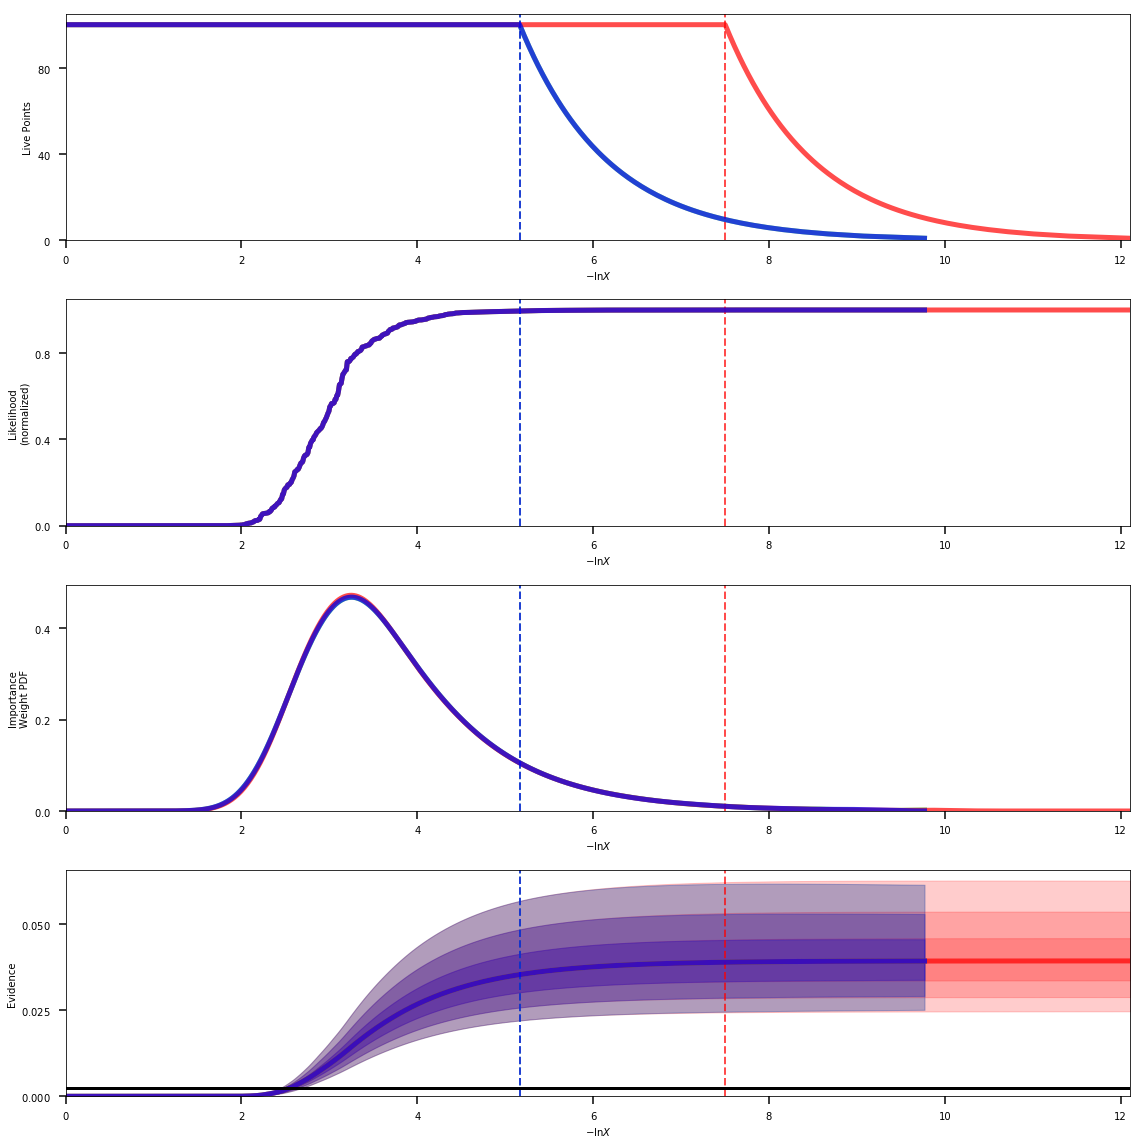

In [116]:
# analytic evidence solution
lnz_truth = ndim * -np.log(2 * 10.)  # log(volume) of prior; log(like) is normalized

# plot parallel run
fig, axes = dyplot.runplot(res, color='limegreen')

# plot extended run
fig, axes = dyplot.runplot(res2, color='red', fig=(fig, axes))

# overplot original run
fig, axes = dyplot.runplot(res, color='blue', lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

AssertionError: Samples must be 1- or 2-D.

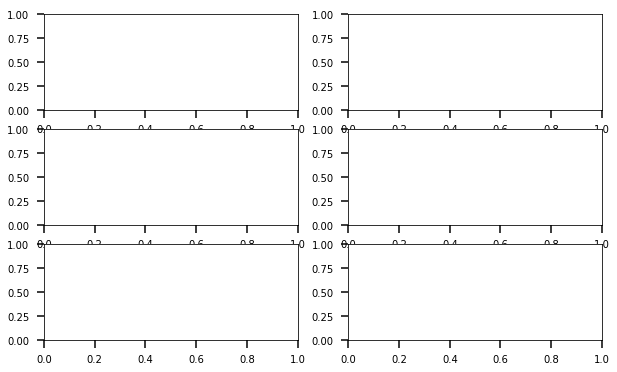

In [119]:

# plotting the original run
fig, axes = dyplot.traceplot(res, truths=[0., 0., 0.], truth_color='black',
                             show_titles=True, title_kwargs={'fontsize': 28, 'y': 1.05},
                             trace_cmap='plasma', kde=False,
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(3, 2, figsize=(10, 6)))
fig.tight_layout()

# plotting the continued run
fig, axes = dyplot.traceplot(res2, truths=[0., 0., 0.], truth_color='black',
                             show_titles=True, title_kwargs={'fontsize': 28, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(3, 2, figsize=(10, 6)))
fig.tight_layout()

In [120]:
res

         logwt: array([-3175.33425948, -2450.6134787 , -1218.74596599, -1084.7626662 ,
       -1067.3219524 ,  -987.67031708,  -875.67352337,  -527.98295388,
        -215.49498513,  -201.6613041 ,  -196.91626053,  -195.20027981,
        -179.30456984,  -178.02109038,  -174.60776426,  -173.77653251,
        -173.40191633,  -171.917088  ,  -171.01554554,  -170.11498711,
        -169.23299247,  -168.56540366,  -167.15133245,  -166.58311321,
        -164.75143723,  -163.85935487,  -163.52676338,  -163.23705979,
        -161.90783171,  -160.93970184,  -157.71745744,  -156.97703389,
        -152.89272075,  -148.12333296,  -146.78052877,  -144.6466709 ,
        -143.00337047,  -141.88663437,  -138.23361079,  -137.39801357,
        -134.46131978,  -132.47720677,  -131.6209574 ,  -129.2999336 ,
        -126.58904633,  -125.7951788 ,  -125.52585859,  -125.21310677,
        -123.81905507,  -123.02691276,  -122.61455157,  -121.1856714 ,
        -119.83123065,  -118.79648065,  -117.62861452,  -114.